In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor()])
# 훈련 데이터셋 로드
# Using local dataset paths instead of Kaggle dataset paths
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# 모델 정의
class Model1(nn.Module):  # 2 layer no dropout
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class Model2(nn.Module):  # 2 layer dropout
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
class Model3(nn.Module):  # 3-layer model
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 3 * 128, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 3 * 3 * 128) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Criterion과 Optimizer 정의
criterions = [nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss()]
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
NB_EPOCH = 10
# 실험 결과를 저장하기 위한 딕셔너리
experiment_losses = {}

# 실험 진행 함수
def train_model(model, criterion, optimizer, epochs=10):
    model.to(device)
    model.train()
    loss_values = []  # 에포크별 손실을 추적하는 리스트
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                # BCEWithLogitsLoss를 위한 타겟 변환
                target = torch.nn.functional.one_hot(target, num_classes=10).float()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)  # 평균 손실값 추가

    # 실험 결과 저장
    experiment_label = f'{model.__class__.__name__} with {criterion.__class__.__name__} and {optimizer.__class__.__name__}'
    experiment_losses[experiment_label] = loss_values


cuda


100%|██████████| 26421880/26421880 [00:01<00:00, 17111288.52it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268898.93it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5013204.95it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9579537.26it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



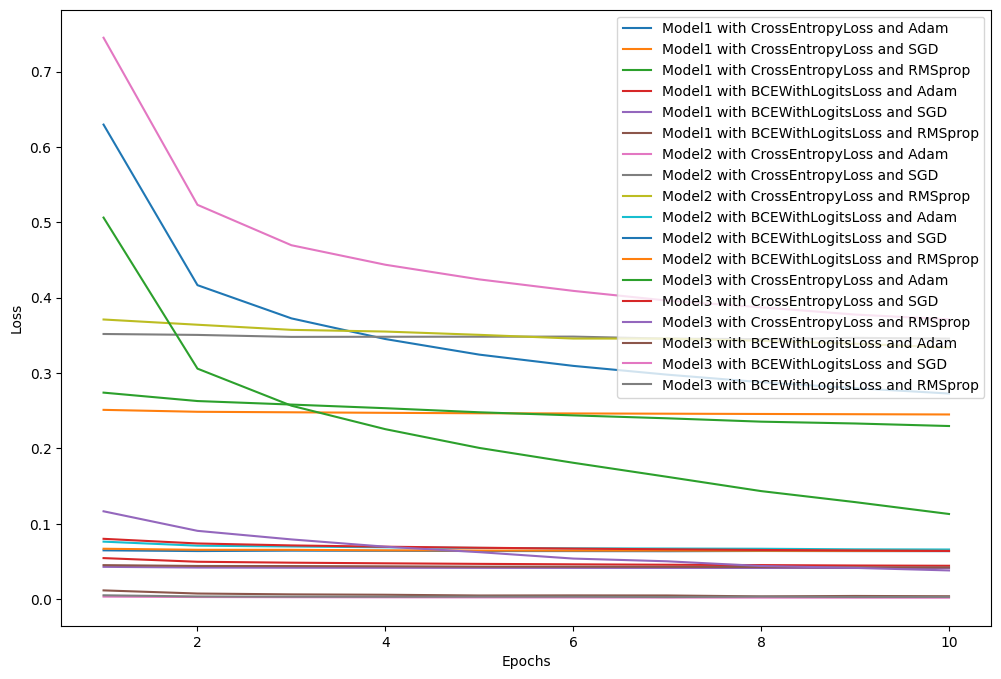

In [4]:
# 모델, Criterion, Optimizer 조합
models = [Model1(), Model2(), Model3()]
for model in models:
    for criterion in criterions:
        for opt_class in optimizers:
            optimizer = opt_class(model.parameters(), lr=0.001)
            train_model(model, criterion, optimizer,epochs = NB_EPOCH)

# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(12, 8))
for experiment_label, loss_values in experiment_losses.items():
    plt.plot(range(1, NB_EPOCH+1), loss_values, label=experiment_label)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# 모든 실험의 손실 텍스트로 출력 및 최소 손실 추적
lowest_loss = float('inf')
best_experiment = None

for experiment_label, loss_values in experiment_losses.items():
    print(f"Experiment: {experiment_label}")
    for epoch, loss in enumerate(loss_values, 1):
        if epoch == 10:
            print(f"  Epoch {epoch}: Loss = {loss:.4f}")
    print()

    # 최소 손실 추적
    min_loss = min(loss_values)
    if min_loss < lowest_loss:
        lowest_loss = min_loss
        best_experiment = experiment_label

# 가장 낮은 손실 값을 가진 실험과 해당 손실 값 출력
print(f"Best Experiment: {best_experiment}")
print(f"Lowest Loss: {lowest_loss:.4f}")


Experiment: Model1 with CrossEntropyLoss and Adam
  Epoch 10: Loss = 0.2729

Experiment: Model1 with CrossEntropyLoss and SGD
  Epoch 10: Loss = 0.2451

Experiment: Model1 with CrossEntropyLoss and RMSprop
  Epoch 10: Loss = 0.2298

Experiment: Model1 with BCEWithLogitsLoss and Adam
  Epoch 10: Loss = 0.0444

Experiment: Model1 with BCEWithLogitsLoss and SGD
  Epoch 10: Loss = 0.0415

Experiment: Model1 with BCEWithLogitsLoss and RMSprop
  Epoch 10: Loss = 0.0422

Experiment: Model2 with CrossEntropyLoss and Adam
  Epoch 10: Loss = 0.3713

Experiment: Model2 with CrossEntropyLoss and SGD
  Epoch 10: Loss = 0.3457

Experiment: Model2 with CrossEntropyLoss and RMSprop
  Epoch 10: Loss = 0.3339

Experiment: Model2 with BCEWithLogitsLoss and Adam
  Epoch 10: Loss = 0.0660

Experiment: Model2 with BCEWithLogitsLoss and SGD
  Epoch 10: Loss = 0.0638

Experiment: Model2 with BCEWithLogitsLoss and RMSprop
  Epoch 10: Loss = 0.0641

Experiment: Model3 with CrossEntropyLoss and Adam
  Epoch 10: 

# Final Fit
Model 3  
RMSprop
BCEWithLL

In [6]:
model = Model3()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
train_model(model, criterion, optimizer,epochs = 10)

In [7]:
from tqdm import  tqdm
# 테스트 데이터셋 로드
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses = []
train_accuracies = []

def evaluate_model(model, test_loader, criterion, device):
    model.to(device)  # 모델을 GPU로 이동
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            target_one_hot = F.one_hot(target, num_classes=10).float()
            test_loss += criterion(output, target_one_hot).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

100%|██████████| 157/157 [00:01<00:00, 119.54it/s]

Test Loss: 0.0009, Test Accuracy: 90.07%
